In [106]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
path1 = r"C:\Users\abebe\Documents\George Mason University\6- SUMME 2023\Team-SkySci-Analytics\Metadata Merge Transform\ground_weather_merged.csv"
path2 = r"C:\Users\abebe\Documents\George Mason University\6- SUMME 2023\Team-SkySci-Analytics\Atmospheric Data Scraper\atmospheric_data_master.csv"

In [68]:
atmosphericData = pd.read_csv(path2)
groundWeatehrData = pd.read_csv(path1)
atmosphericData.tail()
# pressure units seems like is in units of pascal, which we will convert to hpa

,Timestamp,Latitude,Longitude,Temperature,Humidity,Pressure
7682683,2022-12-23 23:00:00,38.066033,-75.512216,211.694427,1.890851,30799.997711
7682684,2022-12-23 23:00:00,38.048988,-75.363237,211.131927,2.140851,30499.997711
7682685,2022-12-23 23:00:00,38.031813,-75.214305,210.569427,2.265851,30099.997711
7682686,2022-12-23 23:00:00,38.165567,-76.407075,213.444427,1.515851,36699.997711
7682687,2022-12-23 23:00:00,39.934715,-75.160969,212.381927,1.890851,30099.997711


In [69]:
# Group the DataFrame by longitude and latitude
grouped_data = atmosphericData.groupby(['Longitude', 'Latitude'])

# Iterate over the groups
for group, group_df in grouped_data:
# Print longitude, latitude, and the corresponding data for each group to look at all the available coordinates
    print("Longitude:", group[0])
    print("Latitude:", group[1])
    print("Grouped data:")
    print(group_df)
    print()

Longitude: -79.98575527109776
Latitude: 35.40078346599076
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
950      2022-09-01 00:00:00  35.400783 -79.985755   205.100800  7.036933   
1855     2022-09-01 00:00:00  35.400783 -79.985755   205.432175  6.669195   
3259     2022-09-01 01:00:00  35.400783 -79.985755   205.244629  6.918959   
4170     2022-09-01 01:00:00  35.400783 -79.985755   205.269501  6.805294   
6566     2022-09-01 02:00:00  35.400783 -79.985755   205.346100  6.683174   
...                      ...        ...        ...          ...       ...   
7676122  2022-12-23 21:00:00  35.400783 -79.985755   208.602615  2.921849   
7677112  2022-12-23 22:00:00  35.400783 -79.985755   208.974991  2.935882   
7678513  2022-12-23 22:00:00  35.400783 -79.985755   209.642914  2.684650   
7680825  2022-12-23 23:00:00  35.400783 -79.985755   209.565125  2.685125   
7681736  2022-12-23 23:00:00  35.400783 -79.985755   209.631927  2.640851   

   

Latitude: 38.97333429596427
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
119      2022-09-01 00:00:00  38.973334 -79.784122   210.975800  2.536933   
2686     2022-09-01 00:00:00  38.973334 -79.784122   210.557175  2.669195   
3861     2022-09-01 01:00:00  38.973334 -79.784122   209.644501  3.055294   
4587     2022-09-01 01:00:00  38.973334 -79.784122   210.494629  2.668959   
5734     2022-09-01 02:00:00  38.973334 -79.784122   209.846100  2.933174   
...                      ...        ...        ...          ...       ...   
7676956  2022-12-23 21:00:00  38.973334 -79.784122   213.040115  1.671849   
7678822  2022-12-23 22:00:00  38.973334 -79.784122   213.330414  1.559650   
7679757  2022-12-23 22:00:00  38.973334 -79.784122   213.662491  1.560882   
7679994  2022-12-23 23:00:00  38.973334 -79.784122   213.315125  1.560125   
7682569  2022-12-23 23:00:00  38.973334 -79.784122   212.944427  1.765851   

             Pressure  
119      

[5472 rows x 6 columns]

Longitude: -79.57290678667354
Latitude: 37.2848971222653
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
1069     2022-09-01 00:00:00  37.284897 -79.572907   207.600800  4.536933   
1735     2022-09-01 00:00:00  37.284897 -79.572907   207.682175  4.419195   
3138     2022-09-01 01:00:00  37.284897 -79.572907   207.619629  4.543959   
3656     2022-09-01 01:00:00  37.284897 -79.572907   207.519501  4.555294   
6685     2022-09-01 02:00:00  37.284897 -79.572907   207.658600  4.433174   
...                      ...        ...        ...          ...       ...   
7676006  2022-12-23 21:00:00  37.284897 -79.572907   213.915115  1.546849   
7677823  2022-12-23 22:00:00  37.284897 -79.572907   214.662491  1.310882   
7679027  2022-12-23 22:00:00  37.284897 -79.572907   214.642914  1.309650   
7680944  2022-12-23 23:00:00  37.284897 -79.572907   214.627625  1.310125   
7681619  2022-12-23 23:00:00  37.284897 -79.572907   214.

[5472 rows x 6 columns]

Longitude: -79.39009016474743
Latitude: 37.50749475470112
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
1221     2022-09-01 00:00:00  37.507495  -79.39009   207.850800  4.286933   
1583     2022-09-01 00:00:00  37.507495  -79.39009   207.994675  4.169195   
2985     2022-09-01 01:00:00  37.507495  -79.39009   207.869629  4.168959   
3724     2022-09-01 01:00:00  37.507495  -79.39009   208.082001  4.055294   
6836     2022-09-01 02:00:00  37.507495  -79.39009   208.221100  3.933174   
...                      ...        ...        ...          ...       ...   
7675853  2022-12-23 21:00:00  37.507495  -79.39009   214.602615  1.296849   
7677755  2022-12-23 22:00:00  37.507495  -79.39009   215.349991  1.185882   
7678959  2022-12-23 22:00:00  37.507495  -79.39009   215.142914  1.184650   
7681105  2022-12-23 23:00:00  37.507495  -79.39009   215.127625  1.185125   
7681467  2022-12-23 23:00:00  37.507495  -79.39009   214

[5472 rows x 6 columns]

Longitude: -79.2081256510291
Latitude: 39.752462237850594
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
367      2022-09-01 00:00:00  39.752462 -79.208126   211.725800  2.286933   
2439     2022-09-01 00:00:00  39.752462 -79.208126   211.807175  2.294195   
5216     2022-09-01 01:00:00  39.752462 -79.208126   211.332001  2.430294   
5471     2022-09-01 01:00:00  39.752462 -79.208126   211.682129  2.293959   
5982     2022-09-01 02:00:00  39.752462 -79.208126   211.533600  2.308174   
...                      ...        ...        ...          ...       ...   
7676709  2022-12-23 21:00:00  39.752462 -79.208126   216.727615  1.046849   
7677467  2022-12-23 22:00:00  39.752462 -79.208126   216.205414  1.059650   
7679486  2022-12-23 22:00:00  39.752462 -79.208126   216.599991  1.060882   
7680242  2022-12-23 23:00:00  39.752462 -79.208126   216.190125  1.060125   
7682320  2022-12-23 23:00:00  39.752462 -79.208126   215

[5472 rows x 6 columns]

Longitude: -79.03823282099378
Latitude: 39.85550300069392
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
376      2022-09-01 00:00:00  39.855503 -79.038233   211.788300  2.286933   
2429     2022-09-01 00:00:00  39.855503 -79.038233   211.869675  2.169195   
5184     2022-09-01 01:00:00  39.855503 -79.038233   211.457001  2.305294   
5372     2022-09-01 01:00:00  39.855503 -79.038233   211.744629  2.293959   
5991     2022-09-01 02:00:00  39.855503 -79.038233   211.721100  2.183174   
...                      ...        ...        ...          ...       ...   
7676567  2022-12-23 21:00:00  39.855503 -79.038233   216.790115  1.046849   
7677499  2022-12-23 22:00:00  39.855503 -79.038233   216.267914  1.059650   
7679498  2022-12-23 22:00:00  39.855503 -79.038233   216.787491  1.060882   
7680293  2022-12-23 23:00:00  39.855503 -79.038233   216.252625  1.060125   
7682310  2022-12-23 23:00:00  39.855503 -79.038233   215

[5472 rows x 6 columns]

Longitude: -78.83707809556613
Latitude: 38.17287636918071
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
269      2022-09-01 00:00:00  38.172876 -78.837078   209.288300  3.411933   
2544     2022-09-01 00:00:00  38.172876 -78.837078   208.994675  3.419195   
3931     2022-09-01 01:00:00  38.172876 -78.837078   209.082001  3.305294   
5044     2022-09-01 01:00:00  38.172876 -78.837078   208.932129  3.543959   
5885     2022-09-01 02:00:00  38.172876 -78.837078   209.283600  3.308174   
...                      ...        ...        ...          ...       ...   
7676784  2022-12-23 21:00:00  38.172876 -78.837078   215.540115  1.296849   
7678753  2022-12-23 22:00:00  38.172876 -78.837078   216.517914  1.059650   
7679607  2022-12-23 22:00:00  38.172876 -78.837078   216.037491  1.185882   
7680145  2022-12-23 23:00:00  38.172876 -78.837078   216.502625  1.060125   
7682419  2022-12-23 23:00:00  38.172876 -78.837078   215

[5472 rows x 6 columns]

Longitude: -78.62432401769996
Latitude: 36.59604193759829
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
1232     2022-09-01 00:00:00  36.596042 -78.624324   207.100800  5.161933   
1571     2022-09-01 00:00:00  36.596042 -78.624324   206.807175  5.294195   
2973     2022-09-01 01:00:00  36.596042 -78.624324   206.744629  5.418959   
4350     2022-09-01 01:00:00  36.596042 -78.624324   206.519501  5.555294   
6848     2022-09-01 02:00:00  36.596042 -78.624324   206.658600  5.433174   
...                      ...        ...        ...          ...       ...   
7675819  2022-12-23 21:00:00  36.596042 -78.624324   211.977615  1.921849   
7678053  2022-12-23 22:00:00  36.596042 -78.624324   212.162491  1.810882   
7678333  2022-12-23 22:00:00  36.596042 -78.624324   211.830414  1.934650   
7681129  2022-12-23 23:00:00  36.596042 -78.624324   211.815125  1.935125   
7681455  2022-12-23 23:00:00  36.596042 -78.624324   211

Longitude: -78.41766539897795
Latitude: 35.009507517051574
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
926      2022-09-01 00:00:00  35.009508 -78.417665   204.975800  7.661933   
1879     2022-09-01 00:00:00  35.009508 -78.417665   205.119675  7.544195   
3283     2022-09-01 01:00:00  35.009508 -78.417665   204.994629  7.668959   
4216     2022-09-01 01:00:00  35.009508 -78.417665   205.144501  7.555294   
6542     2022-09-01 02:00:00  35.009508 -78.417665   205.283600  7.308174   
...                      ...        ...        ...          ...       ...   
7676127  2022-12-23 21:00:00  35.009508 -78.417665   207.102615  3.796849   
7677132  2022-12-23 22:00:00  35.009508 -78.417665   207.474991  3.560882   
7678467  2022-12-23 22:00:00  35.009508 -78.417665   208.017914  3.309650   
7680801  2022-12-23 23:00:00  35.009508 -78.417665   207.940125  3.435125   
7681760  2022-12-23 23:00:00  35.009508 -78.417665   208.444427  2.890851   

  

[5472 rows x 6 columns]

Longitude: -78.23628423126742
Latitude: 35.232708707017245
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
894      2022-09-01 00:00:00  35.232709 -78.236284   205.163300  7.411933   
1911     2022-09-01 00:00:00  35.232709 -78.236284   205.432175  7.044195   
3315     2022-09-01 01:00:00  35.232709 -78.236284   205.307129  7.293959   
4182     2022-09-01 01:00:00  35.232709 -78.236284   205.332001  7.305294   
6510     2022-09-01 02:00:00  35.232709 -78.236284   205.471100  7.058174   
...                      ...        ...        ...          ...       ...   
7676178  2022-12-23 21:00:00  35.232709 -78.236284   207.165115  3.671849   
7677202  2022-12-23 22:00:00  35.232709 -78.236284   207.662491  3.435882   
7678501  2022-12-23 22:00:00  35.232709 -78.236284   208.392914  3.184650   
7680769  2022-12-23 23:00:00  35.232709 -78.236284   208.315125  3.185125   
7681792  2022-12-23 23:00:00  35.232709 -78.236284   20

[5472 rows x 6 columns]

Longitude: -78.03395824072678
Latitude: 37.49729072449324
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
1178     2022-09-01 00:00:00  37.497291 -78.033958   207.913300  4.411933   
1626     2022-09-01 00:00:00  37.497291 -78.033958   207.994675  4.294195   
3028     2022-09-01 01:00:00  37.497291 -78.033958   207.994629  4.293959   
3569     2022-09-01 01:00:00  37.497291 -78.033958   207.957001  4.180294   
6793     2022-09-01 02:00:00  37.497291 -78.033958   208.158600  4.058174   
...                      ...        ...        ...          ...       ...   
7675905  2022-12-23 21:00:00  37.497291 -78.033958   213.852615  1.546849   
7677778  2022-12-23 22:00:00  37.497291 -78.033958   214.349991  1.435882   
7679114  2022-12-23 22:00:00  37.497291 -78.033958   214.455414  1.309650   
7681053  2022-12-23 23:00:00  37.497291 -78.033958   214.377625  1.310125   
7681510  2022-12-23 23:00:00  37.497291 -78.033958   213

[5472 rows x 6 columns]

Longitude: -77.83412615156587
Latitude: 35.91527618468285
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
737      2022-09-01 00:00:00  35.915276 -77.834126   206.288300  6.036933   
2067     2022-09-01 00:00:00  35.915276 -77.834126   206.057175  6.294195   
3470     2022-09-01 01:00:00  35.915276 -77.834126   205.932129  6.418959   
4119     2022-09-01 01:00:00  35.915276 -77.834126   205.707001  6.555294   
6354     2022-09-01 02:00:00  35.915276 -77.834126   205.908600  6.308174   
...                      ...        ...        ...          ...       ...   
7676344  2022-12-23 21:00:00  35.915276 -77.834126   208.665115  2.921849   
7677888  2022-12-23 22:00:00  35.915276 -77.834126   208.412491  3.060882   
7678565  2022-12-23 22:00:00  35.915276 -77.834126   208.642914  3.059650   
7680621  2022-12-23 23:00:00  35.915276 -77.834126   208.565125  3.060125   
7681949  2022-12-23 23:00:00  35.915276 -77.834126   208

[5472 rows x 6 columns]

Longitude: -77.65173371419473
Latitude: 39.8425248037828
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
523      2022-09-01 00:00:00  39.842525 -77.651734   212.100800  2.161933   
2291     2022-09-01 00:00:00  39.842525 -77.651734   212.619675  2.044195   
5400     2022-09-01 01:00:00  39.842525 -77.651734   212.432129  2.168959   
5550     2022-09-01 01:00:00  39.842525 -77.651734   212.457001  2.055294   
6130     2022-09-01 02:00:00  39.842525 -77.651734   212.721100  1.933174   
...                      ...        ...        ...          ...       ...   
7676561  2022-12-23 21:00:00  39.842525 -77.651734   214.540115  1.421849   
7677198  2022-12-23 22:00:00  39.842525 -77.651734   214.642914  1.434650   
7679360  2022-12-23 22:00:00  39.842525 -77.651734   214.662491  1.435882   
7680389  2022-12-23 23:00:00  39.842525 -77.651734   214.565125  1.435125   
7682172  2022-12-23 23:00:00  39.842525 -77.651734   214.

[5472 rows x 6 columns]

Longitude: -77.4665433865456
Latitude: 39.11151578133308
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
664      2022-09-01 00:00:00  39.111516 -77.466543   211.475800  2.411933   
2141     2022-09-01 00:00:00  39.111516 -77.466543   210.807175  2.669195   
4802     2022-09-01 01:00:00  39.111516 -77.466543   210.682129  2.793959   
5292     2022-09-01 01:00:00  39.111516 -77.466543   210.144501  2.930294   
6279     2022-09-01 02:00:00  39.111516 -77.466543   210.283600  2.933174   
...                      ...        ...        ...          ...       ...   
7676388  2022-12-23 21:00:00  39.111516 -77.466543   213.290115  1.671849   
7677390  2022-12-23 22:00:00  39.111516 -77.466543   214.767914  1.309650   
7679211  2022-12-23 22:00:00  39.111516 -77.466543   214.349991  1.435882   
7680538  2022-12-23 23:00:00  39.111516 -77.466543   214.690125  1.310125   
7682022  2022-12-23 23:00:00  39.111516 -77.466543   215.

Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
641      2022-09-01 00:00:00  39.330069  -77.27615   211.913300  2.161933   
2165     2022-09-01 00:00:00  39.330069  -77.27615   211.369675  2.419195   
4735     2022-09-01 01:00:00  39.330069  -77.27615   211.244629  2.543959   
5096     2022-09-01 01:00:00  39.330069  -77.27615   210.644501  2.805294   
6256     2022-09-01 02:00:00  39.330069  -77.27615   210.783600  2.683174   
...                      ...        ...        ...          ...       ...   
7676655  2022-12-23 21:00:00  39.330069  -77.27615   213.227615  1.671849   
7677587  2022-12-23 22:00:00  39.330069  -77.27615   214.455414  1.434650   
7679234  2022-12-23 22:00:00  39.330069  -77.27615   214.287491  1.435882   
7680516  2022-12-23 23:00:00  39.330069  -77.27615   214.377625  1.435125   
7682046  2022-12-23 23:00:00  39.330069  -77.27615   215.319427  1.265851   

             Pressure  
641      15599.997711  
2165     1599

Longitude: -77.07451460739499
Latitude: 38.714086136989046
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
584      2022-09-01 00:00:00  38.714086 -77.074515   209.475800  3.286933   
2221     2022-09-01 00:00:00  38.714086 -77.074515   209.307175  3.419195   
4569     2022-09-01 01:00:00  38.714086 -77.074515   209.182129  3.543959   
5263     2022-09-01 01:00:00  38.714086 -77.074515   209.269501  3.430294   
6199     2022-09-01 02:00:00  38.714086 -77.074515   209.471100  3.433174   
...                      ...        ...        ...          ...       ...   
7676491  2022-12-23 21:00:00  38.714086 -77.074515   211.915115  1.921849   
7677421  2022-12-23 22:00:00  38.714086 -77.074515   213.767914  1.559650   
7679291  2022-12-23 22:00:00  38.714086 -77.074515   212.787491  1.685882   
7680459  2022-12-23 23:00:00  38.714086 -77.074515   213.690125  1.560125   
7682102  2022-12-23 23:00:00  38.714086 -77.074515   214.444427  1.390851   

  

[5472 rows x 6 columns]

Longitude: -76.8929758398856
Latitude: 39.76586615757283
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
509      2022-09-01 00:00:00  39.765866 -76.892976   212.225800  2.036933   
2296     2022-09-01 00:00:00  39.765866 -76.892976   212.557175  2.044195   
5395     2022-09-01 01:00:00  39.765866 -76.892976   212.369629  2.168959   
5490     2022-09-01 01:00:00  39.765866 -76.892976   212.019501  2.305294   
6125     2022-09-01 02:00:00  39.765866 -76.892976   212.221100  2.183174   
...                      ...        ...        ...          ...       ...   
7676588  2022-12-23 21:00:00  39.765866 -76.892976   213.165115  1.671849   
7677193  2022-12-23 22:00:00  39.765866 -76.892976   213.830414  1.559650   
7679365  2022-12-23 22:00:00  39.765866 -76.892976   213.599991  1.560882   
7680384  2022-12-23 23:00:00  39.765866 -76.892976   213.815125  1.560125   
7682177  2022-12-23 23:00:00  39.765866 -76.892976   214.

[5472 rows x 6 columns]

Longitude: -76.72358014899338
Latitude: 35.43468395880653
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
986      2022-09-01 00:00:00  35.434684  -76.72358   205.538300  6.911933   
1822     2022-09-01 00:00:00  35.434684  -76.72358   205.682175  6.669195   
3234     2022-09-01 01:00:00  35.434684  -76.72358   205.557129  6.793959   
4090     2022-09-01 01:00:00  35.434684  -76.72358   205.519501  6.805294   
6589     2022-09-01 02:00:00  35.434684  -76.72358   205.658600  6.683174   
...                      ...        ...        ...          ...       ...   
7676065  2022-12-23 21:00:00  35.434684  -76.72358   207.415115  3.671849   
7677258  2022-12-23 22:00:00  35.434684  -76.72358   207.474991  3.435882   
7678593  2022-12-23 22:00:00  35.434684  -76.72358   207.580414  3.434650   
7680883  2022-12-23 23:00:00  35.434684  -76.72358   207.502625  3.560125   
7681679  2022-12-23 23:00:00  35.434684  -76.72358   207

[5472 rows x 6 columns]

Longitude: -76.56905920991542
Latitude: 39.85078919300357
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
443      2022-09-01 00:00:00  39.850789 -76.569059   212.288300  2.036933   
2362     2022-09-01 00:00:00  39.850789 -76.569059   212.619675  1.919195   
5512     2022-09-01 01:00:00  39.850789 -76.569059   212.144501  2.180294   
5571     2022-09-01 01:00:00  39.850789 -76.569059   212.369629  2.043959   
6059     2022-09-01 02:00:00  39.850789 -76.569059   212.346100  2.183174   
...                      ...        ...        ...          ...       ...   
7676597  2022-12-23 21:00:00  39.850789 -76.569059   212.790115  1.796849   
7677171  2022-12-23 22:00:00  39.850789 -76.569059   213.392914  1.684650   
7679431  2022-12-23 22:00:00  39.850789 -76.569059   213.162491  1.685882   
7680318  2022-12-23 23:00:00  39.850789 -76.569059   213.315125  1.685125   
7682243  2022-12-23 23:00:00  39.850789 -76.569059   214

Latitude: 36.48417166600009
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
1392     2022-09-01 00:00:00  36.484172   -76.3971   206.600800  5.786933   
1444     2022-09-01 00:00:00  36.484172   -76.3971   206.307175  6.169195   
2846     2022-09-01 01:00:00  36.484172   -76.3971   206.307129  6.043959   
4398     2022-09-01 01:00:00  36.484172   -76.3971   206.082001  6.305294   
6984     2022-09-01 02:00:00  36.484172   -76.3971   206.346100  6.058174   
...                      ...        ...        ...          ...       ...   
7675671  2022-12-23 21:00:00  36.484172   -76.3971   207.790115  3.296849   
7677674  2022-12-23 22:00:00  36.484172   -76.3971   209.037491  2.810882   
7678284  2022-12-23 22:00:00  36.484172   -76.3971   209.455414  2.684650   
7681278  2022-12-23 23:00:00  36.484172   -76.3971   209.377625  2.685125   
7681285  2022-12-23 23:00:00  36.484172   -76.3971   209.569427  2.640851   

             Pressure  
1392     

[5472 rows x 6 columns]

Longitude: -76.21979951878794
Latitude: 39.21930692385071
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
524      2022-09-01 00:00:00  39.219307   -76.2198   210.413300  2.786933   
2282     2022-09-01 00:00:00  39.219307   -76.2198   209.994675  2.919195   
5090     2022-09-01 01:00:00  39.219307   -76.2198   209.869629  3.168959   
5103     2022-09-01 01:00:00  39.219307   -76.2198   209.957001  3.180294   
6139     2022-09-01 02:00:00  39.219307   -76.2198   210.096100  3.183174   
...                      ...        ...        ...          ...       ...   
7676662  2022-12-23 21:00:00  39.219307   -76.2198   210.915115  2.296849   
7677580  2022-12-23 22:00:00  39.219307   -76.2198   212.517914  1.809650   
7679264  2022-12-23 22:00:00  39.219307   -76.2198   211.912491  1.935882   
7680289  2022-12-23 23:00:00  39.219307   -76.2198   212.440125  1.810125   
7682273  2022-12-23 23:00:00  39.219307   -76.2198   213

                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
184      2022-09-01 00:00:00  37.528921 -76.064286   207.663300  5.161933   
2630     2022-09-01 00:00:00  37.528921 -76.064286   207.432175  5.169195   
3585     2022-09-01 01:00:00  37.528921 -76.064286   207.394501  4.930294   
4928     2022-09-01 01:00:00  37.528921 -76.064286   207.432129  5.043959   
5791     2022-09-01 02:00:00  37.528921 -76.064286   207.658600  4.683174   
...                      ...        ...        ...          ...       ...   
7676855  2022-12-23 21:00:00  37.528921 -76.064286   209.477615  2.546849   
7679099  2022-12-23 22:00:00  37.528921 -76.064286   211.580414  1.934650   
7679701  2022-12-23 22:00:00  37.528921 -76.064286   210.662491  2.310882   
7680076  2022-12-23 23:00:00  37.528921 -76.064286   211.565125  1.935125   
7682478  2022-12-23 23:00:00  37.528921 -76.064286   211.944427  1.890851   

             Pressure  
184      18499.997711  
2630     18299.997711  
358

Longitude: -75.89390067827458
Latitude: 36.78879705044314
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
1122     2022-09-01 00:00:00  36.788797 -75.893901   206.850800  5.536933   
1682     2022-09-01 00:00:00  36.788797 -75.893901   206.619675  5.794195   
3085     2022-09-01 01:00:00  36.788797 -75.893901   206.682129  5.668959   
3647     2022-09-01 01:00:00  36.788797 -75.893901   206.582001  5.805294   
6738     2022-09-01 02:00:00  36.788797 -75.893901   206.783600  5.558174   
...                      ...        ...        ...          ...       ...   
7675974  2022-12-23 21:00:00  36.788797 -75.893901   207.415115  3.421849   
7677634  2022-12-23 22:00:00  36.788797 -75.893901   208.912491  2.810882   
7679036  2022-12-23 22:00:00  36.788797 -75.893901   209.830414  2.559650   
7680996  2022-12-23 23:00:00  36.788797 -75.893901   209.815125  2.560125   
7681567  2022-12-23 23:00:00  36.788797 -75.893901   210.381927  2.265851   

   

Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
1280     2022-09-01 00:00:00  36.046393 -75.725826   206.600800  5.536933   
1524     2022-09-01 00:00:00  36.046393 -75.725826   206.369675  5.794195   
2935     2022-09-01 01:00:00  36.046393 -75.725826   206.432129  5.793959   
4500     2022-09-01 01:00:00  36.046393 -75.725826   205.957001  6.305294   
6897     2022-09-01 02:00:00  36.046393 -75.725826   206.096100  6.058174   
...                      ...        ...        ...          ...       ...   
7675793  2022-12-23 21:00:00  36.046393 -75.725826   208.290115  3.171849   
7678101  2022-12-23 22:00:00  36.046393 -75.725826   208.349991  3.060882   
7678183  2022-12-23 22:00:00  36.046393 -75.725826   208.142914  3.184650   
7681155  2022-12-23 23:00:00  36.046393 -75.725826   208.127625  3.185125   
7681407  2022-12-23 23:00:00  36.046393 -75.725826   208.194427  3.265851   

             Pressure  
1280     22399.997711  
1524     2269

[5472 rows x 6 columns]

Longitude: -75.57523818158273
Latitude: 38.551727556196425
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
574      2022-09-01 00:00:00  38.551728 -75.575238   208.725800  3.911933   
2231     2022-09-01 00:00:00  38.551728 -75.575238   208.682175  3.919195   
4624     2022-09-01 01:00:00  38.551728 -75.575238   208.682129  3.918959   
5273     2022-09-01 01:00:00  38.551728 -75.575238   209.019501  3.805294   
6189     2022-09-01 02:00:00  38.551728 -75.575238   209.283600  3.558174   
...                      ...        ...        ...          ...       ...   
7676457  2022-12-23 21:00:00  38.551728 -75.575238   209.102615  2.796849   
7677411  2022-12-23 22:00:00  38.551728 -75.575238   211.705414  1.934650   
7679301  2022-12-23 22:00:00  38.551728 -75.575238   210.537491  2.310882   
7680470  2022-12-23 23:00:00  38.551728 -75.575238   211.565125  1.935125   
7682112  2022-12-23 23:00:00  38.551728 -75.575238   21

[5472 rows x 6 columns]

Longitude: -75.38195522869196
Latitude: 38.768761389005775
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
551      2022-09-01 00:00:00  38.768761 -75.381955   209.163300  3.661933   
2254     2022-09-01 00:00:00  38.768761 -75.381955   208.932175  3.669195   
4821     2022-09-01 01:00:00  38.768761 -75.381955   208.932129  3.668959   
5340     2022-09-01 01:00:00  38.768761 -75.381955   209.269501  3.555294   
6166     2022-09-01 02:00:00  38.768761 -75.381955   209.533600  3.433174   
...                      ...        ...        ...          ...       ...   
7676392  2022-12-23 21:00:00  38.768761 -75.381955   208.977615  2.796849   
7677344  2022-12-23 22:00:00  38.768761 -75.381955   211.330414  2.059650   
7679324  2022-12-23 22:00:00  38.768761 -75.381955   210.224991  2.310882   
7680535  2022-12-23 23:00:00  38.768761 -75.381955   211.315125  2.060125   
7682135  2022-12-23 23:00:00  38.768761 -75.381955   21

Latitude: 35.74108744617052
Grouped data:
                   Timestamp   Latitude  Longitude  Temperature  Humidity  \
861      2022-09-01 00:00:00  35.741087 -75.184087   206.225800  5.911933   
1943     2022-09-01 00:00:00  35.741087 -75.184087   206.057175  6.044195   
3346     2022-09-01 01:00:00  35.741087 -75.184087   206.119629  6.043959   
4435     2022-09-01 01:00:00  35.741087 -75.184087   205.769501  6.430294   
6478     2022-09-01 02:00:00  35.741087 -75.184087   205.908600  6.308174   
...                      ...        ...        ...          ...       ...   
7676211  2022-12-23 21:00:00  35.741087 -75.184087   208.102615  3.296849   
7677902  2022-12-23 22:00:00  35.741087 -75.184087   208.037491  3.310882   
7678249  2022-12-23 22:00:00  35.741087 -75.184087   207.517914  3.434650   
7680736  2022-12-23 23:00:00  35.741087 -75.184087   207.502625  3.435125   
7681825  2022-12-23 23:00:00  35.741087 -75.184087   208.069427  3.265851   

             Pressure  
861      

In [54]:
#selected area of coordinates 

long = -77.28391389676462
lat= 38.37780115022908

In [55]:
# Checking if there are datapoint within the selected alt and long coordinates 
selected_data = atmosphericData[(atmosphericData['Latitude'] == lat) & (atmosphericData['Longitude'] == long)]
if len(selected_data) > 0:
    print("There are rows with the specified latitude and longitude.")
else:
    print("There are no rows with the specified latitude and longitude.")

There are rows with the specified latitude and longitude.


### Converting Pressure and Calculating Altitude Levels 

The altitude calculation was based on the following resources, which are also utilized for pressure conversion.

* https://www.weather.gov/media/epz/wxcalc/pressureAltitude.pdf
* https://www.weather.gov/media/epz/wxcalc/pressureConversion.pdf
* https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
* https://www.weather.gov/media/epz/wxcalc/tempConvert.pdf



In [70]:
def calculate_altitude(Pressure):
    altitude = (1 - ((Pressure/100) / 1013.25) ** 0.190284) * 145366.45  #  divide presssure 100 to convert it from Pascal to hpa
    return round(altitude, 3)
selected_data.loc[:, 'Altitude (feet)'] = calculate_altitude(selected_data['Pressure'])
selected_data.sort_values('Altitude (feet)', ascending=False).head(30)

,Timestamp,Latitude,Longitude,Temperature,Humidity,Pressure,Altitude (feet)
4537698,2022-11-07 07:00:00,38.377801,-77.283914,204.324646,6.172859,10799.997711,50425.758
4557410,2022-11-07 15:00:00,38.377801,-77.283914,204.040527,8.052935,10799.997711,50425.758
4567183,2022-11-07 18:00:00,38.377801,-77.283914,203.788406,8.205587,10799.997711,50425.758
4564378,2022-11-07 17:00:00,38.377801,-77.283914,204.235962,7.798562,10799.997711,50425.758
4561626,2022-11-07 16:00:00,38.377801,-77.283914,204.395035,7.549213,10799.997711,50425.758
4560227,2022-11-07 16:00:00,38.377801,-77.283914,204.179016,7.922430,10799.997711,50425.758
4558818,2022-11-07 15:00:00,38.377801,-77.283914,204.405106,7.549004,10799.997711,50425.758
7613864,2022-12-22 23:00:00,38.377801,-77.283914,209.887970,2.439675,10799.997711,50425.758
7615324,2022-12-23 00:00:00,38.377801,-77.283914,209.610168,2.588052,10799.997711,50425.758
4546121,2022-11-07 10:00:00,38.377801,-77.283914,204.070953,7.145676,10799.997711,50425.758


In [71]:
selected_data.shape

(5472, 7)

In [72]:
print( round(min(selected_data['Altitude (feet)']),2))
print( round(max(selected_data['Altitude (feet)']),2))


19015.62
50425.76


### Merging Atmospheric Data with Ground weather data

In [73]:
Atm_data = selected_data.groupby('Timestamp').max().reset_index().rename(columns={'Timestamp': 'Datetime'})

# Strip the last date from the atmospheric data to ensure consistency with the ground surface weather data
Atm_data = Atm_data[~Atm_data['Datetime'].str.contains('2022-12-23')]
print ("RAP Atmospheric Data")
print(Atm_data.shape)

print ("Ground Surface Data")
grd_data = groundWeatehrData.groupby('Datetime').mean('Temperature')
print(grd_data.shape)

RAP Atmospheric Data
(2712, 7)
Ground Surface Data
(2674, 15)


In [74]:
combined_data = pd.merge(Atm_data, grd_data, on="Datetime")
#Renaming Ground Temprature and atmoshpheric temprature 
combined_data.rename(columns={'Temperature_x': 'atm_TMP', 'Temperature_y': 'grd_TMP'}, inplace=True)
combined_data.tail(2)

,Datetime,Latitude,Longitude,atm_TMP,Humidity,Pressure,Altitude (feet),grd_TMP,precp,humidity,...,dewPt,Image Present,Low/Mid Clouds (%),High Cirrus (%),Long-lived Contrails (Count),Contrail-Cirrus (Count),Day Low/Mid,Day Count Cirrs,Day Count Cont LL,Day Count Cont-Cirrus
2672,2022-12-21 23:00:00,38.377801,-77.283914,209.927338,2.825494,22299.997711,36944.978,37.0,0.0,54.0,...,22.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2673,2022-12-22 00:00:00,38.377801,-77.283914,209.120422,2.950183,21699.997711,37815.374,32.0,0.0,66.0,...,22.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
#check for missing values
combined_data.isnull().sum().sort_values(ascending=False).head(10)

Day Count Cont-Cirrus           2562
Day Count Cont LL               2562
Day Count Cirrs                 2562
Day Low/Mid                     2562
Long-lived Contrails (Count)    1663
Contrail-Cirrus (Count)         1661
High Cirrus (%)                 1618
Low/Mid Clouds (%)              1347
wspd                               2
humidity                           0
dtype: int64

### Relative Humidity Calculation

The following resources are used to calculate RH and Saturated VP and Actual Vp

* https://www.weather.gov/media/epz/wxcalc/tempConvert.pdf  <<- Temp Convertion 
* https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf <<- RH AND pressure Calculation


**RH = (e / es) * 100**

Where:

- RH is the relative humidity expressed as a percentage
- e is the actual water vapor pressure
- es is the saturation vapor pressure at the same temperature.**

The saturation vapor pressure (es) at a given temperature can be canculated using this formuala :

**es = 6.11 * 10^((7.5 * T) / (237.3 + T))**



In [48]:
#Converting TMP to degree of Celsius #
# combined_data['TMP_C'] = (combined_data['atm_TMP'] - 32) * 5/9
# combined_data['dewPT_C'] = (combined_data['dewPt'] - 32) * 5/9

In [76]:
# Calculate Saturated Vapor Pressure (Saturated_vp )
combined_data['Saturated_vp'] = 6.11 * 10**((7.5 * combined_data['atm_TMP']) / (237.3 + combined_data['atm_TMP']))


combined_data['RH_water'] = ((combined_data['Pressure'])/(combined_data['Saturated_vp'])) *100
combined_data.head(2)

,Datetime,Latitude,Longitude,atm_TMP,Humidity,Pressure,Altitude (feet),grd_TMP,precp,humidity,...,Low/Mid Clouds (%),High Cirrus (%),Long-lived Contrails (Count),Contrail-Cirrus (Count),Day Low/Mid,Day Count Cirrs,Day Count Cont LL,Day Count Cont-Cirrus,Saturated_vp,RH_water
0,2022-09-01 05:00:00,38.377801,-77.283914,209.101562,3.561864,18599.997711,40513.702,68.0,0.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19914.068833,93.401293
1,2022-09-01 06:00:00,38.377801,-77.283914,209.144577,3.317529,18599.997711,41293.313,63.0,0.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19931.690568,93.318716


In [50]:
print( round(min(combined_data['RH_water']),2))
print( round(max(combined_data['RH_water']),2))


51.64
257.9


In [26]:
combined_data['Saturated_vp'] = 6.11 * 10**((7.5 * combined_data['atm_TMP']) / (237.3 + combined_data['atm_TMP']))
combined_data['converted_vp'] = combined_data['Pressure']/100

combined_data['RH_water2'] = ((combined_data['converted_vp'])/(combined_data['Saturated_vp']))*100 
combined_data.head(2)

,Datetime,Latitude,Longitude,atm_TMP,Humidity,Pressure,Altitude(feet),grd_TMP,precp,humidity,...,Long-lived Contrails (Count),Contrail-Cirrus (Count),Day Low/Mid,Day Count Cirrs,Day Count Cont LL,Day Count Cont-Cirrus,Saturated_vp,RH_water,converted_vp,RH_water2
0,2022-09-01 05:00:00,38.377801,-77.283914,209.101562,3.561864,18599.997711,40513.701675,68.0,0.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,19914.068833,93.401293,185.999977,0.934013
1,2022-09-01 06:00:00,38.377801,-77.283914,209.144577,3.317529,18599.997711,41293.312847,63.0,0.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,19931.690568,93.318716,185.999977,0.933187


### Attempting previous model and calculation process to Validate


The following mathematical process was used in the previous partlycloudy teams mathematical application to calculate relative humidity:

In [116]:
import numpy as np

# Constants based on previous model
a_water = 17.2693882  
a_ice = 21.8745484 
b_water = 35.86  
b_ice = 7.66 
RH_ice = combined_data['RH_water']
TMP = combined_data['atm_TMP']

# Define a function to calculate the relative humidity with respect to water
def rh_water(a_water, a_ice, b_water, b_ice, TMP, RH_ice):
    return RH_ice / np.exp(a_water * TMP / (TMP - b_water)) - a_ice * (TMP / (TMP - b_ice))

# Calculate the relative humidity with respect to water
combined_data['Rh_water'] = rh_water(a_water, a_ice, b_water, b_ice, TMP, RH_ice)

# Display the updated
combined_data.head(2)

,Latitude,Longitude,atm_TMP,Humidity,Pressure,Altitude (feet),grd_TMP,precp,humidity,pressure,...,High Cirrus (%),Long-lived Contrails (Count),Contrail-Cirrus (Count),Day Low/Mid,Day Count Cirrs,Day Count Cont LL,Day Count Cont-Cirrus,Saturated_vp,RH_water,Rh_water
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-09-01 05:00:00,38.377801,-77.283914,209.101562,3.561864,18599.997711,40513.702,68.0,0.0,65.0,29.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19914.068833,93.401293,-22.706348
2022-09-01 06:00:00,38.377801,-77.283914,209.144577,3.317529,18599.997711,41293.313,63.0,0.0,78.0,29.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19931.690568,93.318716,-22.706170


In [111]:
# combined_data.reset_index()

In [122]:
# Convert the datetime column to Timestamp format
combined_data.reset_index(inplace=True)

In [128]:
combined_data['Datetime']= pd.to_datetime(combined_data['Datetime'], format='%Y-%m-%d %H:%M:%S')
combined_data['Datetime'].dtypes

dtype('<M8[ns]')

In [180]:
combined_data.head(40)

,Latitude,Longitude,atm_TMP,Humidity,Pressure,Altitude (feet),grd_TMP,precp,humidity,pressure,...,High Cirrus (%),Long-lived Contrails (Count),Contrail-Cirrus (Count),Day Low/Mid,Day Count Cirrs,Day Count Cont LL,Day Count Cont-Cirrus,Saturated_vp,RH_water,Rh_water
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-09-01 05:00:00,38.377801,-77.283914,209.101562,3.561864,18599.997711,40513.702,68.0,0.0,65.0,29.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19914.068833,93.401293,-22.706348
2022-09-01 06:00:00,38.377801,-77.283914,209.144577,3.317529,18599.997711,41293.313,63.0,0.0,78.0,29.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19931.690568,93.318716,-22.706170
2022-09-01 07:00:00,38.377801,-77.283914,209.605942,3.188781,17399.997711,41635.180,61.0,0.0,83.0,29.64,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,20121.465530,86.474803,-22.704271
2022-09-01 08:00:00,38.377801,-77.283914,209.579147,3.057698,34399.997711,41750.209,60.0,0.0,86.0,29.65,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,20110.405577,171.055713,-22.704381
2022-09-01 09:00:00,38.377801,-77.283914,210.057922,3.078123,40799.997711,23391.046,59.0,0.0,87.0,29.65,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,20308.747575,200.898640,-22.702418
2022-09-01 10:00:00,38.377801,-77.283914,210.191055,2.943742,41499.997711,22877.334,61.0,0.0,87.0,29.66,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,20364.171308,203.789278,-22.701873
2022-09-01 11:00:00,38.377801,-77.283914,210.125443,3.315545,40699.997711,23448.697,61.0,0.0,87.0,29.68,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,20336.841704,200.129392,-22.702142
2022-09-01 12:00:00,38.377801,-77.283914,208.776016,3.689923,33099.997711,44559.501,65.0,0.0,84.0,29.69,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,19781.097252,167.331454,-22.707694
2022-09-01 13:00:00,38.377801,-77.283914,208.987778,3.936039,15099.997711,44430.246,73.0,0.0,66.0,29.71,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,19867.513433,76.003460,-22.706818


## Data Exploration and Visualization

In [186]:
# combined_data.set_index('Datetime', inplace=True
import plotly.express as px

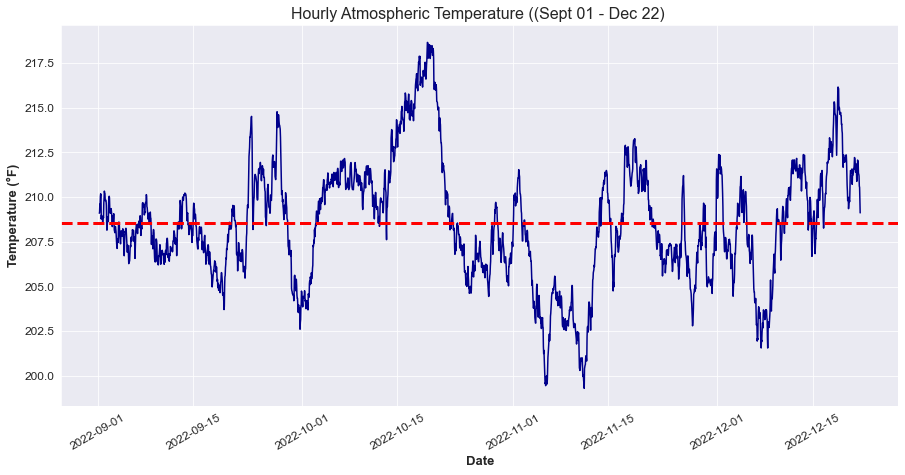

In [230]:
avg_TMP = combined_data['atm_TMP'].mean()

# Plot the temperature data for the entire dataset
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
sns.lineplot(data=combined_data['atm_TMP'], color='darkblue')
# Add the average line
plt.axhline(avg_TMP, color='red', linestyle='--', label='Average', lw='3')

plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Temperature (°F)', fontsize=13, fontweight='bold')
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Hourly Atmospheric Temperature ((Sept 01 - Dec 22) ', fontsize=16, fontweight='400', fontfamily='Arial')

plt.show()

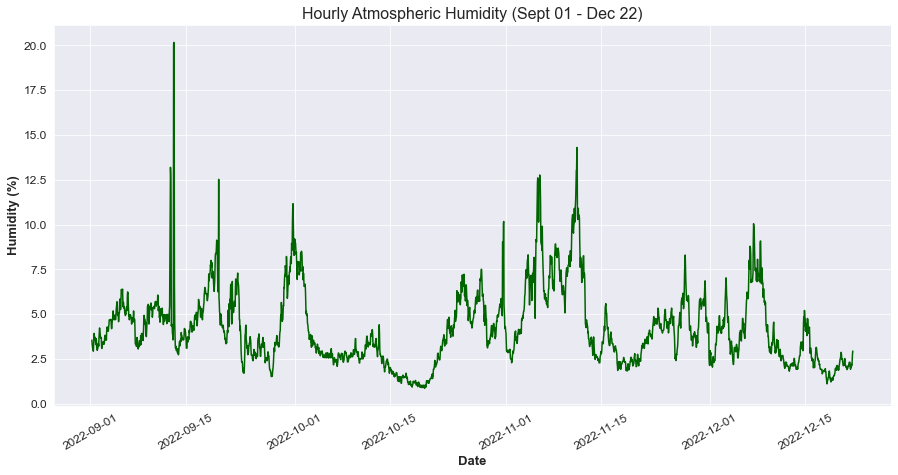

In [232]:
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
sns.lineplot(data=combined_data['Humidity'], color='darkgreen')
plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Humidity (%)', fontsize=13, fontweight='bold')
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Hourly Atmospheric Humidity (Sept 01 - Dec 22)',  fontsize=16, fontweight='400', fontfamily='Arial')

plt.show()

In [188]:
# combined_data.head()

# # # Set the start and end dates of the 4-week span
# Create a subset for the desired 4-week span with midnight data
start_date = pd.Timestamp('2022-09-01 00:00:00')
end_date = start_date + pd.DateOffset(weeks=4)
midnight_subset = combined_data.between_time('00:00', '00:00').loc[start_date:end_date]
morning_subset = combined_data.between_time('06:00', '06:00').loc[start_date:end_date]
afternoon_subset = combined_data.between_time('12:00', '12:00').loc[start_date:end_date]
evening_subset = combined_data.between_time('18:00', '18:00').loc[start_date:end_date]


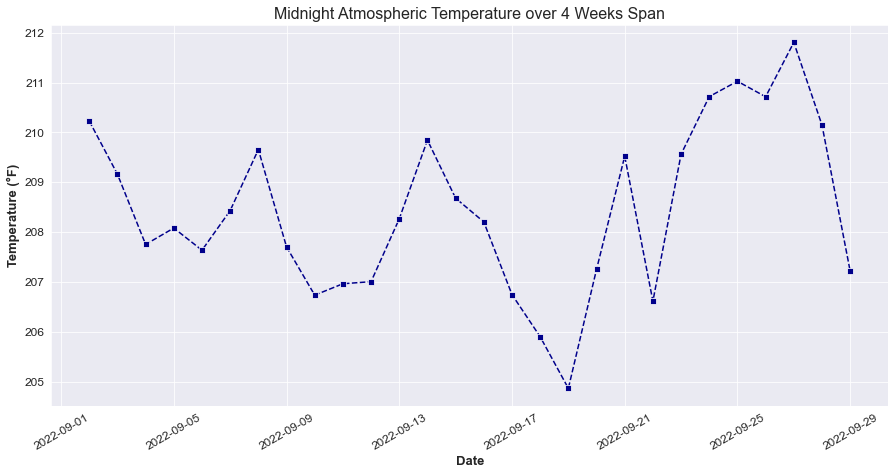

In [221]:
# Plot the temperature data
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
sns.lineplot(data=midnight_subset['atm_TMP'], color='darkblue', ls='dashed', marker='s')

plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Temperature (°F)', fontsize=13, fontweight='bold')
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Midnight Atmospheric Temperature over 4 Weeks Span', fontsize=16, fontweight='400', fontfamily='Arial')

plt.show()

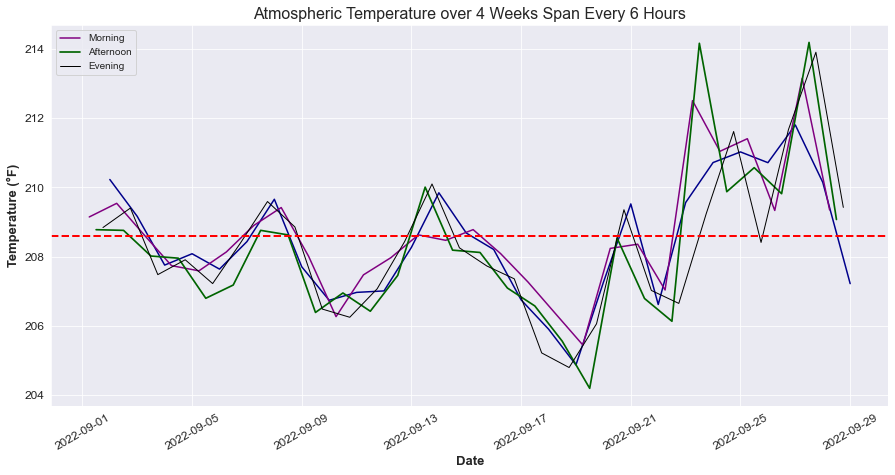

In [249]:
# Plot the temperature data
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
sns.lineplot(data=midnight_subset['atm_TMP'], color='darkblue')


# Plot the morning subset
sns.lineplot(data=morning_subset['atm_TMP'], color='purple', label='Morning', linestyle='solid' )
# Plot the afternoon subset
sns.lineplot(data=afternoon_subset['atm_TMP'], color='darkgreen', label='Afternoon', linestyle='solid', lw='1.7')
# Plot the evening subset
sns.lineplot(data=evening_subset['atm_TMP'], color='black', label='Evening', lw='1')
# Add the average line
plt.axhline(avg_TMP, color='red', linestyle='--', label='Average', lw='2'
           )

plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Temperature (°F)', fontsize=13, fontweight='bold')
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Atmospheric Temperature over 4 Weeks Span Every 6 Hours', fontsize=16, fontweight='400', fontfamily='Arial')

plt.show()